In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.preprocessing import image  
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import pandas as pd
import numpy as np
import secrets
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rotation_range = 5
width_shift_range = 0.02
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

In [3]:
datagen = ImageDataGenerator(
        rotation_range = rotation_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        shear_range = shear_range,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip,
        fill_mode = fill_mode)

In [4]:
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")

In [5]:
# Generate augmented images and save them to the train_augmented directory
for class_name in os.listdir(TRAIN_DIR):
    class_dir = os.path.join(TRAIN_DIR, class_name)
    output_dir = os.path.join("train_augmented", class_name)
    os.makedirs(output_dir, exist_ok=True)
    
    # Load images from the class directory
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    num_images_per_class = len(images)  # Get the number of images in the class folder
    
    # Apply data augmentation and save the augmented images
    for img_path in images:
        img = load_img(img_path, target_size=(64, 64))  # Load image
        x = img_to_array(img)  # Convert image to numpy array
        x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)
        
        # Generate augmented images and save them
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix=class_name, save_format='jpg'):
            i += 1
            if i >= 9:
                break

print("Data augmentation completed.")

Data augmentation completed.


In [6]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(filename,index=False)

create_csv('train_augmented',"train.csv")

In [7]:
data_train = pd.read_csv("train.csv")

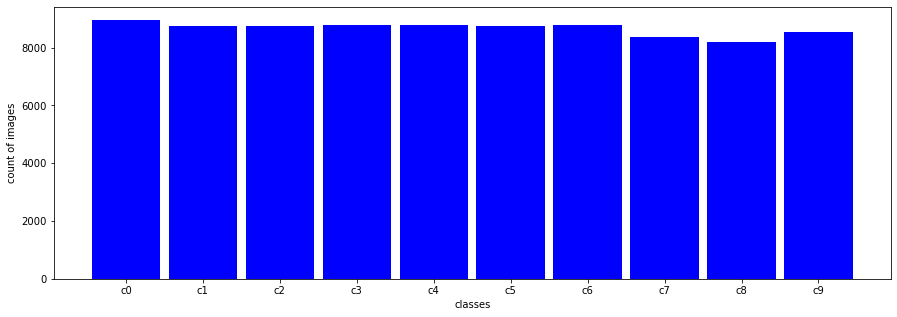

In [8]:
plt.figure(figsize=(15,5))
x = data_train["ClassName"].value_counts(sort=False).to_numpy()
y = data_train["ClassName"].value_counts(sort=False).index.to_numpy()
plt.bar(y,x,0.88888,color='blue')
plt.xlabel("classes")
plt.ylabel("count of images")
plt.show()

In [9]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_list.sort()
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


In [10]:
import pickle
with open(os.path.join("labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [11]:
from keras.utils import to_categorical
labels = to_categorical(data_train['ClassName'])

In [12]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

In [13]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64,64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in (img_paths)]
    return np.vstack(list_of_tensors)

train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

In [14]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(64, 64, 3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\rajes\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 512)           │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │       1,024,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,727,206 (6.59 MB)

 Trainable params: 1,727,206 (6.59 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_freq='epoch')
callbacks_list = [checkpoint]

In [16]:
model_history = model.fit(train_tensors,
                          ytrain,
                          validation_data = (valid_tensors, ytest),
                          epochs=18,
                          batch_size=40,
                          shuffle=True,
                          callbacks=callbacks_list
                          )

Epoch 1/18
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5524 - loss: 1.1843
Epoch 1: val_accuracy improved from -inf to 0.96057, saving model to model.keras
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 179s 102ms/step - accuracy: 0.5525 - loss: 1.1840 - val_accuracy: 0.9606 - val_loss: 0.1254
Epoch 2/18
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9556 - loss: 0.1415
Epoch 2: val_accuracy improved from 0.96057 to 0.98540, saving model to model.keras
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 169s 97ms/step - accuracy: 0.9556 - loss: 0.1415 - val_accuracy: 0.9854 - val_loss: 0.0496
Epoch 3/18
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9756 - loss: 0.0783
Epoch 3: val_accuracy did not improve from 0.98540
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 166s 96ms/step - accuracy: 0.9756 - loss: 0.0783 - val_accuracy: 0.9853 - val_loss: 0.0472
Epoch 4/18
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9822 - loss: 0.0577
Epoch 4: val_accuracy improved from 0.98540 to 0.98736, savin

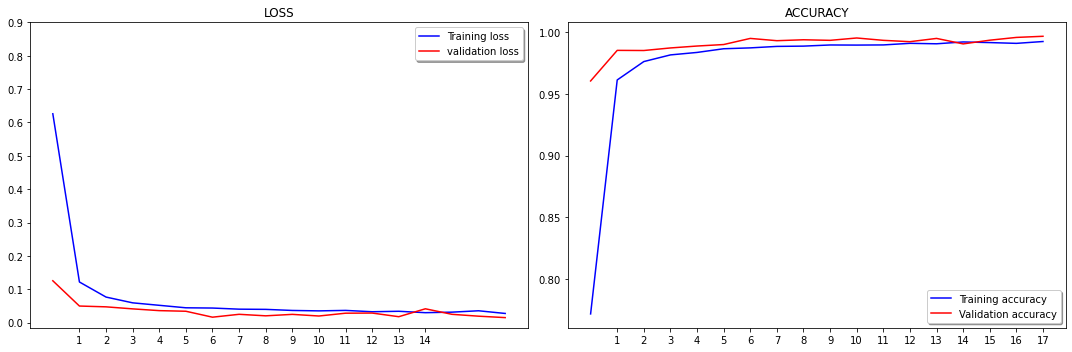

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 15, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.title.set_text("LOSS")

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 18, 1))
ax2.title.set_text("ACCURACY")

ax1.legend(loc='best', shadow=True)
ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

In [18]:
val = ['normal driving',
      ' texting - right',
      'talking on the phone - right',
      'texting - left',
      'talking on the phone - left',
      'operating the radio',
      'drinking',
      'reaching behind',
      'hair and makeup',
      'talking to passenger'
      ]

In [19]:
from tensorflow.keras.models import load_model
loadmodel = load_model("model.keras")
loadmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
results = loadmodel.evaluate(valid_tensors,ytest)
print("\nＡＣＣＵＲＡＣＹ　ＯＦ　ＭＯＤＥＬ on 　ＩＳ : %f"%(results[1]*100))
print("\nＭＳＥ　ＯＦ　ＭＯＤＥＬ　ＩＳ : %f"%(results[0]))

542/542 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9968 - loss: 0.0128

ＡＣＣＵＲＡＣＹ　ＯＦ　ＭＯＤＥＬ on 　ＩＳ : 99.682522

ＭＳＥ　ＯＦ　ＭＯＤＥＬ　ＩＳ : 0.014965
